In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler



In [42]:
# Load sentiment data
sentiment_df = pd.read_csv("lst_price/final_perday_bt.csv")
sentiment_df.rename(columns={"date": "Date"}, inplace=True)
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])

# Load price data
price_df = pd.read_csv("lst_price/BTCUSDT_closing.csv")
price_df.rename(columns={"Open Time": "Date", "Close": "Close_Price"}, inplace=True)
price_df["Date"] = pd.to_datetime(price_df["Date"])

# Merge on Date
merged_df = pd.merge(sentiment_df, price_df, on="Date", how="inner")
merged_df.sort_values("Date", inplace=True)

# Reset index for modeling
merged_df.reset_index(drop=True, inplace=True)

merged_df

,Date,compound,Close_Price
0,2022-12-12,-0.118424,17209.83
1,2022-12-13,-0.201185,17774.70
2,2022-12-14,-0.052566,17803.15
3,2022-12-15,-0.057588,17356.34
4,2022-12-16,-0.055825,16632.12
...,...,...,...
991,2025-08-29,0.069189,108377.40
992,2025-08-30,0.067619,108816.33
993,2025-08-31,0.160374,108246.35
994,2025-09-01,0.233910,109237.42


In [43]:
# --- Feature Preparation with Train-Test Split ---
from sklearn.model_selection import train_test_split

SEQ_LEN = 30  # Number of past days to use
features = []
targets = []

for i in range(SEQ_LEN, len(merged_df)):
    past_sentiment = merged_df["compound"].values[i - SEQ_LEN : i]
    past_price = merged_df["Close_Price"].values[i - SEQ_LEN : i]
    current_sentiment = merged_df["compound"].values[i]
    x = np.concatenate([past_sentiment, past_price, [current_sentiment]])
    features.append(x)
    # Target is next day's price
    if i + 1 < len(merged_df):
        targets.append(merged_df["Close_Price"].values[i + 1])

# Remove last feature if it doesn't have a corresponding target
if len(features) > len(targets):
    features = features[: len(targets)]

features = np.array(features)
targets = np.array(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, shuffle=False)

# Normalize features and targets
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [44]:

# --- LSTM Model Definition ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last output
        out = self.fc(out)
        return out


input_size = X.shape[1]
hidden_size = 32
model = LSTMModel(input_size=input_size, hidden_size=hidden_size)


In [ ]:
# --- Training Loop (Train on Train Data) ---
input_size = X_train_tensor.shape[1]
hidden_size = 32
model = LSTMModel(input_size=input_size, hidden_size=hidden_size)

epochs = 10000
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Reshape for LSTM: (batch, seq_len=1, input_size)
X_train_lstm = X_train_tensor.unsqueeze(1)
X_test_lstm = X_test_tensor.unsqueeze(1)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_lstm)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/1000, Loss: 1.1140
Epoch 20/1000, Loss: 1.0733
Epoch 30/1000, Loss: 1.0336
Epoch 40/1000, Loss: 0.9948
Epoch 50/1000, Loss: 0.9571
Epoch 60/1000, Loss: 0.9203
Epoch 70/1000, Loss: 0.8845
Epoch 80/1000, Loss: 0.8495
Epoch 90/1000, Loss: 0.8154
Epoch 100/1000, Loss: 0.7820
Epoch 110/1000, Loss: 0.7493
Epoch 120/1000, Loss: 0.7174
Epoch 130/1000, Loss: 0.6862
Epoch 70/1000, Loss: 0.8845
Epoch 80/1000, Loss: 0.8495
Epoch 90/1000, Loss: 0.8154
Epoch 100/1000, Loss: 0.7820
Epoch 110/1000, Loss: 0.7493
Epoch 120/1000, Loss: 0.7174
Epoch 130/1000, Loss: 0.6862
Epoch 140/1000, Loss: 0.6558
Epoch 150/1000, Loss: 0.6262
Epoch 160/1000, Loss: 0.5976
Epoch 170/1000, Loss: 0.5699
Epoch 180/1000, Loss: 0.5432
Epoch 190/1000, Loss: 0.5175
Epoch 200/1000, Loss: 0.4929
Epoch 210/1000, Loss: 0.4692
Epoch 140/1000, Loss: 0.6558
Epoch 150/1000, Loss: 0.6262
Epoch 160/1000, Loss: 0.5976
Epoch 170/1000, Loss: 0.5699
Epoch 180/1000, Loss: 0.5432
Epoch 190/1000, Loss: 0.5175
Epoch 200/1000, Loss: 0.49

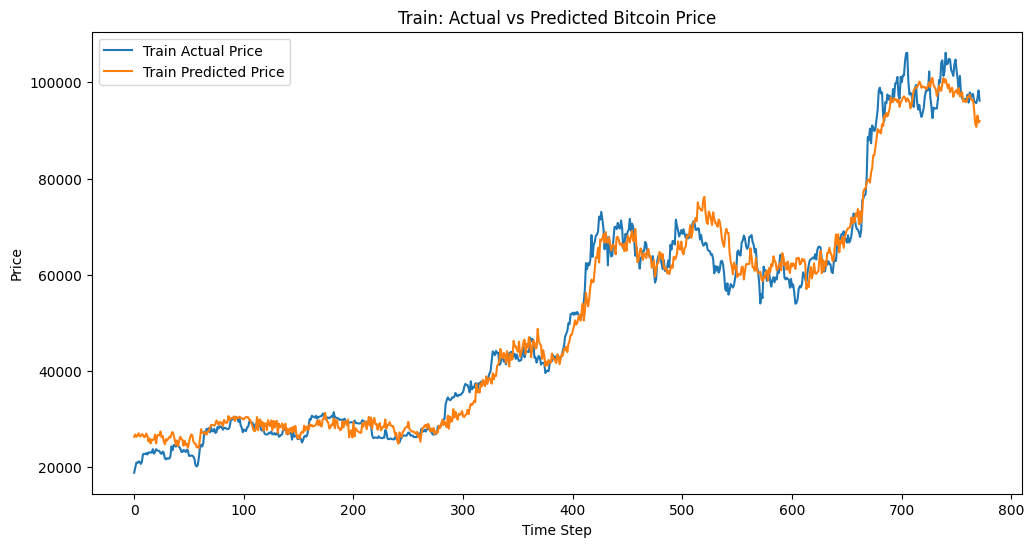

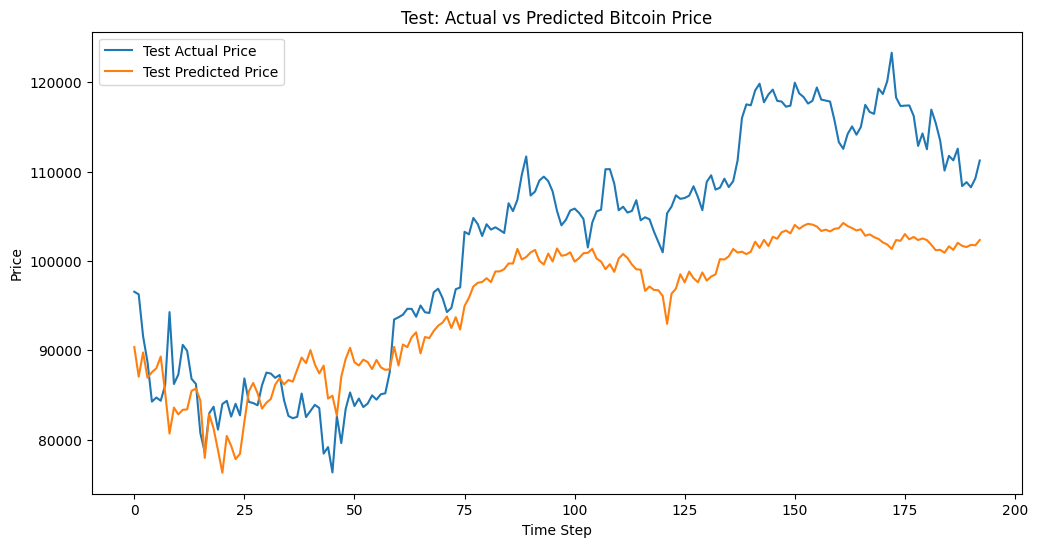

First 10 Train Actual: [18846.621 19930.01  20954.92  20871.498 21185.65  21134.81  20677.47
 21071.59  22667.209 22783.549]
First 10 Train Predicted: [26319.68  26791.309 26336.414 26464.1   27043.363 26502.717 26409.006
 26870.111 26732.37  26248.746]
First 10 Test Actual: [96551.01 96258.   91552.88 88680.4  84250.09 84708.58 84349.94 86064.53
 94270.   86220.61]
First 10 Test Predicted: [90361.61  87042.69  89755.58  86926.59  87544.84  87979.96  89294.45
 85303.984 80672.85  83579.45 ]


In [46]:
# Evaluate model predictions vs actual values for train and test
model.eval()
with torch.no_grad():
    # Train predictions
    train_pred_norm = model(X_train_lstm).squeeze().numpy()
    train_actual_norm = y_train_tensor.squeeze().numpy()
    train_pred = scaler_y.inverse_transform(train_pred_norm.reshape(-1, 1)).flatten()
    train_actual = scaler_y.inverse_transform(train_actual_norm.reshape(-1, 1)).flatten()
    # Test predictions
    test_pred_norm = model(X_test_lstm).squeeze().numpy()
    test_actual_norm = y_test_tensor.squeeze().numpy()
    test_pred = scaler_y.inverse_transform(test_pred_norm.reshape(-1, 1)).flatten()
    test_actual = scaler_y.inverse_transform(test_actual_norm.reshape(-1, 1)).flatten()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(train_actual, label='Train Actual Price')
plt.plot(train_pred, label='Train Predicted Price')
plt.title('Train: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_actual, label='Test Actual Price')
plt.plot(test_pred, label='Test Predicted Price')
plt.title('Test: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Optionally, print sample values
print('First 10 Train Actual:', train_actual[:10])
print('First 10 Train Predicted:', train_pred[:10])
print('First 10 Test Actual:', test_actual[:10])
print('First 10 Test Predicted:', test_pred[:10])